<a href="https://colab.research.google.com/github/monokim/BERT/blob/master/Intent_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Check If there is a GPU available.

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print(torch.cuda.get_device_name(0), 'will be used.')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Tesla P4 will be used.


IMDB Movie review Dataset

In [5]:
"""
import pandas as pd

# Load the data set into a pandas dataframe
df = pd.read_csv("./Dataset/IMDB_Dataset.csv", delimiter=',', header=None, names=['review', 'sentiment'])

df.sample(10)

# Print number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
sentences = df.review.values[1000:]
labels = df.sentiment.values[1000:]
labels = [1 if l == 'positive' else 0 for l in labels]

print(sentences[:3])
print(labels[:3])
"""

'\nimport pandas as pd\n\n# Load the data set into a pandas dataframe\ndf = pd.read_csv("./Dataset/IMDB_Dataset.csv", delimiter=\',\', header=None, names=[\'review\', \'sentiment\'])\n\ndf.sample(10)\n\n# Print number of sentences.\nprint(\'Number of training sentences: {:,}\n\'.format(df.shape[0]))\nsentences = df.review.values[1000:]\nlabels = df.sentiment.values[1000:]\nlabels = [1 if l == \'positive\' else 0 for l in labels]\n\nprint(sentences[:3])\nprint(labels[:3])\n'

AG NEWS Dataset

In [6]:
import pandas as pd

# Load the data set into a pandas dataframe
df = pd.read_csv("./Dataset/ag_news_train.csv", delimiter=',', header=None, names=['category', "head", 'content'])

df.sample(10)

# Print number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
sentences = df.content.values
labels = df.category.values - 1

print(sentences[:3])
print(labels[:3])

Number of training sentences: 120,000

["Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."
 'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'
 'Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.']
[2 2 2]


# BERT Tokenizer

Tokenize each words and convert to token IDs

In [7]:
# Install transformers by using pip
!pip install transformers

     |████████████████████████████████| 573kB 28.3MB/s 
     |████████████████████████████████| 3.7MB 50.0MB/s 
     |████████████████████████████████| 1.0MB 49.3MB/s 
     |████████████████████████████████| 890kB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=018c9cce0be14d94b9f5d781cbb7f49055c1c12aea968dd208e9269cba72ec4a
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [8]:
from transformers import BertTokenizer

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Original : ', sentences[0])
print('Tokenized : ', tokenizer.tokenize(sentences[0]))
print('Token IDs : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


Original :  Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Tokenized :  ['reuters', '-', 'short', '-', 'sellers', ',', 'wall', 'street', "'", 's', 'd', '##wind', '##ling', '\\', 'band', 'of', 'ultra', '-', 'cy', '##nic', '##s', ',', 'are', 'seeing', 'green', 'again', '.']
Token IDs :  [26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330, 8713, 2015, 1010, 2024, 3773, 2665, 2153, 1012]


Sentence to ID

In [9]:
input_ids = []

for s in sentences:
    encoded_sentence = tokenizer.encode(
        s,
        add_special_tokens=True
    )
    input_ids.append(encoded_sentence)
    
print('original: ', sentences[0])
print('id: ', input_ids[0])
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

original:  Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
id:  [101, 26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330, 8713, 2015, 1010, 2024, 3773, 2665, 2153, 1012, 102]
Max sentence length:  372


Add padding and attention masks

In [0]:
def add_padding_and_truncate(input_ids):
    MAX_LEN = 64
    for index, input_id in enumerate(input_ids):
        for i in range(MAX_LEN - len(input_id)):
          input_id.insert(0, 0)
        if len(input_id) > MAX_LEN:
          input_ids[index] = input_id[:MAX_LEN]


In [11]:
# Fit sentence's length to MAX_LEN
add_padding_and_truncate(input_ids)

print('After max question length: ', max([len(id) for id in input_ids]))

attention_masks = []

for id in input_ids:
    att_mask = [int(token_id) > 0 for token_id in id]
    attention_masks.append(att_mask)

After max question length:  64


In [0]:
from sklearn.model_selection import train_test_split

train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)
train_masks, valid_masks, _, _ = train_test_split(attention_masks, labels, random_state=2020, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

# Training

BertForSequenceClassification

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False
)
#model.resize_token_embeddings(len(tokenizer))

if device.type == 'cuda':
  model.cuda()

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                 )

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [0]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  3,375.    Elapsed: 0:00:17.
  Batch    80  of  3,375.    Elapsed: 0:00:34.
  Batch   120  of  3,375.    Elapsed: 0:00:50.
  Batch   160  of  3,375.    Elapsed: 0:01:07.
  Batch   200  of  3,375.    Elapsed: 0:01:24.
  Batch   240  of  3,375.    Elapsed: 0:01:41.
  Batch   280  of  3,375.    Elapsed: 0:01:59.
  Batch   320  of  3,375.    Elapsed: 0:02:16.
  Batch   360  of  3,375.    Elapsed: 0:02:33.
  Batch   400  of  3,375.    Elapsed: 0:02:50.
  Batch   440  of  3,375.    Elapsed: 0:03:08.
  Batch   480  of  3,375.    Elapsed: 0:03:25.
  Batch   520  of  3,375.    Elapsed: 0:03:43.
  Batch   560  of  3,375.    Elapsed: 0:04:00.
  Batch   600  of  3,375.    Elapsed: 0:04:17.
  Batch   640  of  3,375.    Elapsed: 0:04:35.
  Batch   680  of  3,375.    Elapsed: 0:04:52.
  Batch   720  of  3,375.    Elapsed: 0:05:10.
  Batch   760  of  3,375.    Elapsed: 0:05:27.
  Batch   800  of  3,375.    Elapsed: 0:05:44.
  Batch   840  of

Plot

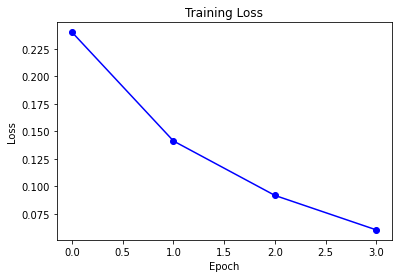

In [26]:
import matplotlib.pyplot as plt

plt.plot(loss_values, 'b-o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# test

In [28]:
import pandas as pd

#df = pd.read_csv("./IMDB_Dataset", delimiter=',', header=None, names=['review', 'sentiment'])
#sentences = df.review.values[1:1000]
#labels = df.sentiment.values[1:1000]
#labels = [1 if l == 'positive' else 0 for l in labels]

df = pd.read_csv("./Dataset/ag_news_test.csv", delimiter=',', header=None, names=['category', "head", 'content'])

# Print number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
sentences = df.content.values
labels = df.category.values - 1

input_ids = []

for s in sentences:
    encoded_sent = tokenizer.encode(
        s,
        add_special_tokens=True
    )
    input_ids.append(encoded_sent)
        
add_padding_and_truncate(input_ids)

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)
    
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


model.eval()

#predictions = []
#true_labels = []

eval_accuracy = 0
eval_steps = 0
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #predictions.append(logits)
    #true_labels.append(label_ids)
    
    eval_accuracy += flat_accuracy(logits, label_ids)
    eval_steps += 1

print("Accuracy: {0:.2f}".format(eval_accuracy/eval_steps))
print("Done")

Number of test sentences: 7,600

Accuracy: 0.94
Done
